# Battle of Neighborhoods
## Scarborough, Canada
### Check Average Prices and School Ratings
The Location: Scarborough is a popular destination for new immigrants in Canada to reside. As a result, it is one of the most diverse and multicultural areas in the Greater Toronto Area, being home to various religious groups and places of worship.

Project Description: The projects aim to create an analysis of features for a neighborhood or a comparative analysis between neighborhoods with just sending out the names of the neighborhoods. The features include like population rate, median house price, school ratings, crime rates, weather conditions, recreational facilities. This would help people to get awareness of the places before moving to a new country, state, city or place for their work or to start a new life

This Project would help users take a better decision on choosing the best neighborhood out of many neighborhoods to move into NewYork city based on the distribution of various facilities in and around that neighborhood.

### Python Packages and Dependencies and Creating data

In [13]:
from bs4 import BeautifulSoup
import requests
import csv
import json
import xml
import pandas as pd

column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(url).text
soup = BeautifulSoup(source, 'lxml')#Beautiful Soup to Parse the url page
table=soup.find('table')
x=table.tbody

postcode = 0
borough = 0
neighborhood = 0

for tr in x.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2:
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)
    
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1
                                 
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()


df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]


def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [14]:
import geocoder

def get_latlng(postal_code):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
    return lat_lng_coords

postal_codes = df2['Postalcode']    
coords = [ get_latlng(postal_code) for postal_code in postal_codes.tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

In [18]:
df = df.head(17)
df.shape

(17, 5)

In [20]:

import json # library to handle JSON files
import xml
import pandas as pd #Python library data manipulation and analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
%matplotlib inline

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
import warnings
warnings.filterwarnings("ignore")

In [21]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The geograpical coordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The geograpical coordinate of Seattle,Washington are 43.773077, -79.257774.


### Map Scarborough Canada

In [22]:
# create map of Toronto using latitude and longitude values
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

# add markers to map
for lat, lng, nei in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [23]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The geograpical coordinate of neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The geograpical coordinate of neighborhood_1 are 43.773077, -79.257774.


In [24]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = ''
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [34]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index([u'reasons.count', u'reasons.items', u'referralId', u'venue.categories',
       u'venue.events.count', u'venue.events.summary', u'venue.id',
       u'venue.location.address', u'venue.location.cc', u'venue.location.city',
       u'venue.location.country', u'venue.location.crossStreet',
       u'venue.location.distance', u'venue.location.formattedAddress',
       u'venue.location.labeledLatLngs', u'venue.location.lat',
       u'venue.location.lng', u'venue.location.neighborhood',
       u'venue.location.postalCode', u'venue.location.state', u'venue.name',
       u'venue.photos.count', u'venue.photos.groups', u'venue.venuePage.id'],
      dtype='object')

In [35]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Nearby Venues

In [36]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head(5)

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Disney Store,"[{u'pluralName': u'Toy / Game Stores', u'prima...",43.775537,-79.256833
1,Canyon Creek Chophouse,"[{u'pluralName': u'Steakhouses', u'primary': T...",43.776959,-79.261694
2,Tommy Hilfiger Company Store,"[{u'pluralName': u'Clothing Stores', u'primary...",43.776015,-79.257369
3,DAVIDsTEA,"[{u'pluralName': u'Tea Rooms', u'primary': Tru...",43.776613,-79.258516
4,American Eagle Outfitters,"[{u'pluralName': u'Clothing Stores', u'primary...",43.775908,-79.258352


In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West, Steeles West
Upper Rouge


In [32]:
print('There are {} uniques categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 69 uniques categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,26,26,26,26,26,26
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",5,5,5,5,5,5
"Birch Cliff, Cliffside West",9,9,9,9,9,9
Cedarbrae,8,8,8,8,8,8
"Clairlea, Golden Mile, Oakridge",16,16,16,16,16,16


### One Hot Coding

In [41]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Neighborhood,African Restaurant,Asian Restaurant,Athletics & Sports,Auto Garage,Bakery,Bank,Bar,Bistro,Breakfast Spot,Burger Joint,Bus Line,Bus Station,Café,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,College Stadium,Convenience Store,Deli / Bodega,Department Store,Diner,Discount Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Fried Chicken Joint,Furniture / Home Store,General Entertainment,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,History Museum,Hobby Shop,Hookah Bar,Indian Restaurant,Intersection,Japanese Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Motorcycle Shop,Other Great Outdoors,Park,Pet Store,Pharmacy,Pizza Place,Pool,Restaurant,Sandwich Place,Seafood Restaurant,Shanghai Restaurant,Shopping Mall,Skating Rink,Soccer Field,Supermarket,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Train Station,Vietnamese Restaurant,Wine Shop,Zoo Exhibit
0,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Highland Creek, Rouge Hill, Port Union",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                venue  freq
0  Chinese Restaurant  0.12
1       Shopping Mall  0.08
2        Skating Rink  0.04
3     Motorcycle Shop  0.04
4            Pharmacy  0.04


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                venue  freq
0            Pharmacy   0.4
1         Coffee Shop   0.2
2      Sandwich Place   0.2
3    Sushi Restaurant   0.2
4  African Restaurant   0.0


----Birch Cliff, Cliffside West----
          venue  freq
0          Park  0.33
1  Skating Rink  0.11
2          Café  0.11
3      Gym Pool  0.11
4           Gym  0.11


----Cedarbrae----
                venue  freq
0    Hakka Restaurant  0.12
1  Athletics & Sports  0.12
2              Bakery  0.12
3                Bank  0.12
4   Indian Restaurant  0.12


----Clairlea, Golden Mile, Oakridge----
         venue  freq
0     Bus Line  0.12
1        Diner  0.12
2       Bakery  0.12
3  Coffee Shop  0.12
4  Bus Station  0.06


----Clarks Corners, Sullivan, Tam O'Shanter----
   

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Most Common venues near neighborhood

In [44]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Shopping Mall,Sandwich Place,Coffee Shop,Malay Restaurant,Mediterranean Restaurant,Breakfast Spot,Department Store,Park,Discount Store
1,"Agincourt North, L'Amoreaux East, Milliken, St...",Pharmacy,Sushi Restaurant,Sandwich Place,Coffee Shop,Zoo Exhibit,Discount Store,Convenience Store,Deli / Bodega,Department Store,Diner
2,"Birch Cliff, Cliffside West",Park,Gym,General Entertainment,Café,Skating Rink,Gym Pool,College Stadium,Furniture / Home Store,Fried Chicken Joint,Flower Shop
3,Cedarbrae,Athletics & Sports,Thai Restaurant,Bakery,Bank,Hakka Restaurant,Caribbean Restaurant,Flower Shop,Indian Restaurant,Zoo Exhibit,Fast Food Restaurant
4,"Clairlea, Golden Mile, Oakridge",Coffee Shop,Bus Line,Bakery,Diner,General Entertainment,Fast Food Restaurant,Intersection,Convenience Store,Park,Bus Station


### k-means Clustering

In [45]:
# set number of clusters
# Using k-means to cluster the neighborhood into 3 clusters.

Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
#Scarborough_grouped_clustering = Scarborough_grouped

# run k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0])

In [46]:
Scarborough_merged =df.iloc[:16,:]

# add clustering labels
Scarborough_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.811650,-79.195561,0,Zoo Exhibit,Fast Food Restaurant,Farmers Market,Convenience Store,Deli / Bodega,Department Store,Diner,Discount Store,Fish & Chips Shop,Gym
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785605,-79.158701,0,Bar,Fish & Chips Shop,History Museum,Zoo Exhibit,Deli / Bodega,Department Store,Diner,Discount Store,Farmers Market,Fast Food Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765690,-79.175299,0,Gym / Fitness Center,Athletics & Sports,Park,Gym,Golf Course,General Entertainment,Furniture / Home Store,Fried Chicken Joint,Flower Shop,Greek Restaurant
3,M1G,Scarborough,Woburn,43.768216,-79.217610,0,Coffee Shop,Chinese Restaurant,Fast Food Restaurant,Park,Golf Course,General Entertainment,Furniture / Home Store,Fried Chicken Joint,Flower Shop,Fish & Chips Shop
4,M1H,Scarborough,Cedarbrae,43.769608,-79.239440,0,Athletics & Sports,Thai Restaurant,Bakery,Bank,Hakka Restaurant,Caribbean Restaurant,Flower Shop,Indian Restaurant,Zoo Exhibit,Fast Food Restaurant


### Map of Clusters

In [64]:
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)
kclusters = 3
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Scarborough_merged['Latitude'], Scarborough_merged['Longitude'], Scarborough_merged['Neighborhood'],Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [50]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

### Average House Prices

In [51]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0]})

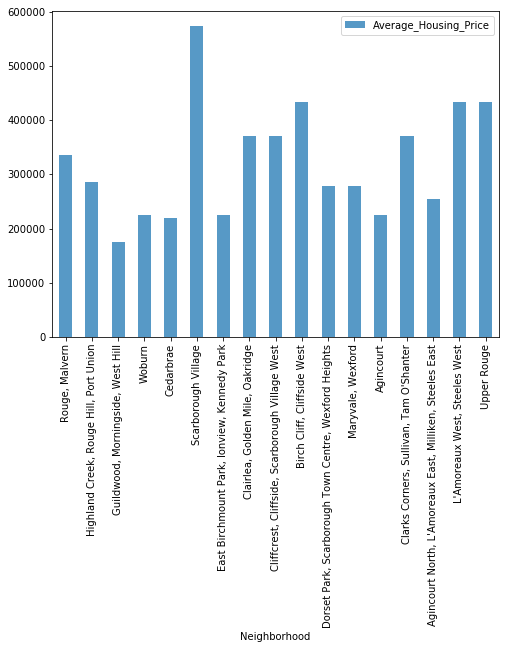

In [52]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(8,6),alpha=0.75)

### School Rating Cluster

In [53]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [54]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,]})

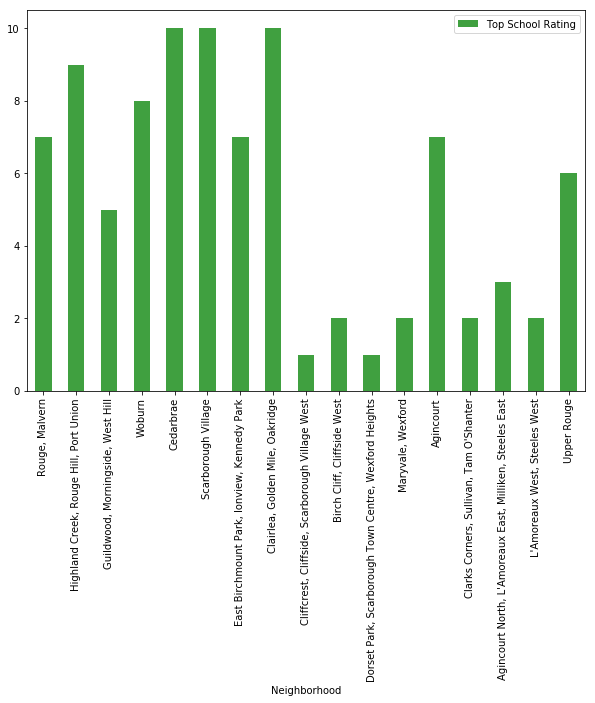

In [55]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

Scarborough_school_ratings.plot(kind='bar',figsize=(10,7),color='green',alpha=0.75);

### Conclusion:
In this project, through a k-means cluster algorithm we separate the neighborhood into 03 clusters, which have similar neighborhoods around them. Using the charts above decision loving to a particular neighborhood based on average house prices and school rating can be made